<a href="https://colab.research.google.com/github/F1ameX/TUSUR_ML/blob/main/TUSUR_HW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Продвинутый вариант выполнения задания


### Подготовка данных

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore') # функция для отключения лишних предупреждений

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/src_4hw/preprocessed_orders_short.csv', index_col = 0)
df = df [['store_id',	'order_price',	'profit', 'delivery_distance', 'planned_prep_time',
         'region_id', 'items_count', 'prepared_on_time']]
df

,store_id,order_price,profit,delivery_distance,planned_prep_time,region_id,items_count,prepared_on_time
0,5014.0,30.49,45.5040,2205.0,15.0,683.0,2.0,1.0
2,3856.0,240.78,30.3360,1368.0,10.0,683.0,2.0,1.0
4,10825.0,85.99,43.6080,459.0,20.0,683.0,1.0,1.0
5,8535.0,80.09,11.3128,1749.0,10.0,685.0,5.0,1.0
10,11449.0,85.99,4.4240,1040.0,20.0,695.0,1.0,1.0
...,...,...,...,...,...,...,...,...
15248,7557.0,277.28,50.1650,8046.0,35.0,683.0,5.0,1.0
15253,4548.0,21.05,14.6150,2225.0,20.0,707.0,2.0,1.0
15255,7099.0,102.11,12.1976,3354.0,25.0,683.0,5.0,1.0
15260,4348.0,43.43,49.2960,2129.0,30.0,683.0,3.0,1.0


Подгружаем основной датасет для выполнения задания и выбираем необходимые колонки из него.

In [ ]:
X = df.drop(['prepared_on_time'], axis = 1)
y = df['prepared_on_time'].copy()

Разбиваем датасет на фичи (колонки X) и целевую переменную (колонка y).

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 52, test_size = 0.3, stratify = y)

Разбиваем на тренировочную и тестовую выборки подготовленные данные. Делаем стратификацию по целевой переменной, чтобы указать, что отношение классов в тренировочном и тестовом датасете такое же, как и в изначальном.

### Исчёрпывающий поиск по сетке GridSearchCV



In [ ]:
from sklearn.tree import DecisionTreeClassifier   # Подключаем дерево решений для предсказаний
from sklearn.model_selection import GridSearchCV  # Подключаем поиск по сетке значений

decision_tree = DecisionTreeClassifier()

param_grid = {                                      # Инициализируем сетку параметров поиска
    'max_depth' : [1, 2, 5, 10, 15, 20, 30, None],  # Параметр максимальной глубины решающего дерева
    'min_samples_leaf' : [1, 2, 5, 10, None],       # Параметр минимального количества элементов в листе (элементе дерева)
    'criterion' : ['gini', 'entropy'],              # Параметр критерия отбора, на котором принимается решения перехода (разделения на элементы)
    'class_weight': ['balanced', {0: 1, 1: 1}, {0: 3, 1: 7}, {0: 7, 1: 3}, {0: 10, 1: 1}]   # Параметр развесовки каждого из классов
}

grid_search = GridSearchCV (estimator = decision_tree,    # Оценивающая модель - дерево решений
                            param_grid = param_grid,      # Применяем к сетке параметры
                            cv = 7,                       # Количество фолдов для разбиения трейна
                            scoring = 'balanced_accuracy' # Метрика оценки - сбалансированная точность
                            )

grid_search.fit(X_train, y_train)         # Тренируем модель на выборке
best_model = grid_search.best_estimator_  # Выбираем лучшую модель
best_params = grid_search.best_params_    # Выбираем лучшие параметры

print("Метрика 'balanced_accuracy' для лучшей модели: ", grid_search.best_score_)
print("Параметры лучшей модели: ", best_params)

Метрика 'balanced_accuracy' для лучшей модели:  0.5402767807566652
Параметры лучшей модели:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10}


По итогу получили сбалансированную точность для лучшей модель в виде 54% и параметры лучшей модели. Видно, что метрика не сильно высокая. Изучив датасет можно видеть, что значений целевой переменной 0 немного и алгоритм не смог найти лучшего варианта зависимостей от X с целевой переменной.

### Визуализация и обучение лучшей модели

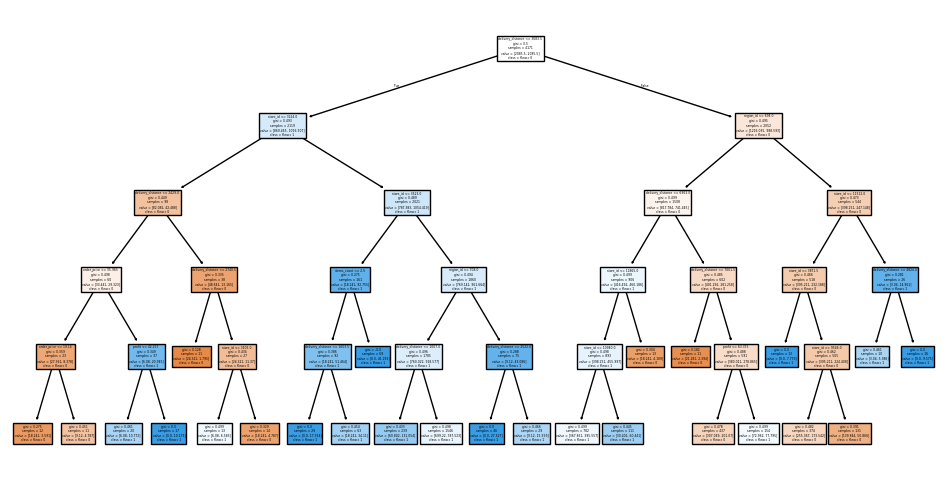

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize = (12, 6))
plot_tree(best_model, filled=True, feature_names = X_train.columns, class_names = ['Класс 0', 'Класс 1'])
plt.show()

На основе лучшей модели построили её визуализацию.

In [ ]:
feature_importances = pd.DataFrame({
    'feature' : X_train.columns,
    'importance' : best_model.feature_importances_
})

feature_importances

,feature,importance
0,store_id,0.378945
1,order_price,0.062416
2,profit,0.032816
3,delivery_distance,0.400208
4,planned_prep_time,0.000000
5,region_id,0.102389
6,items_count,0.023226


Получили 'важность' каждой из переменных из X_train. Параметр показывает насколько она влияет на итоговые предсказания.

In [ ]:
decision_tree = DecisionTreeClassifier(class_weight = 'balanced', criterion = 'gini',
                                       max_depth = 5, min_samples_leaf = 10)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

Обучили дерево решений и получили предсказания для нашей тестовой выборки.

### Финальные метрики

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score

print(classification_report(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.20      0.28      0.24       294
         1.0       0.85      0.78      0.81      1494

    accuracy                           0.70      1788
   macro avg       0.53      0.53      0.53      1788
weighted avg       0.74      0.70      0.72      1788

Accuracy:  0.7013422818791947
Balanced accuracy:  0.533057399666694
Precision:  0.8473227206946454
Recall:  0.7838018741633199
F1:  0.8143254520166898


Модель показывает хороший результат для класса 1.0 с высоким precision (0.85), recall (0.78) и F1-score (0.81), что говорит о её способности правильно классифицировать большинство примеров этого класса. Однако качество для класса 0.0 значительно хуже, с precision 0.20 и recall 0.28, что указывает на проблемы с определением этого класса из-за сильного дисбаланса данных (класс 1.0 представлен гораздо больше). Общая точность модели составляет 70%, но сбалансированная точность всего 53%, что подчеркивает перекос в производительности.